In [1]:
import keras
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

def load_data(features_file_name, labels_file_name, initial_index=0):
    features = np.load(features_file_name)
    labels = np.load(labels_file_name)
    num_rows = labels.size
    features = features[:num_rows]
    print("Feature shape from source: " + str(features.shape))
    print("Label shape from source: " + str(labels.shape))

    labels = np_utils.to_categorical(labels - initial_index)
    print("Sample Label: " + str(labels[0]))

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)
    return (X_train, y_train), (X_test, y_test)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
from keras.utils import HDF5Matrix
from keras.layers.convolutional import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt


/home/grigorii/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = load_data("chunk_100_features.npy", "chunk_100_labels.npy")

Feature shape from source: (7222, 1025, 32, 3)
Label shape from source: (7222, 1)
Sample Label: [1. 0. 0. 0. 0.]


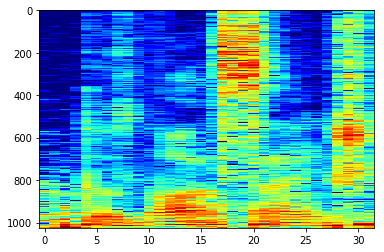

In [3]:
from IPython.core.pylabtools import figsize
plt.imshow(X_train[3], aspect = "auto")


In [4]:
## Zero-centering

r_mean = np.mean(X_train[:,:,:,0])
g_mean = np.mean(X_train[:,:,:,1])
b_mean = np.mean(X_train[:,:,:,2])
X_train[:,:,:,0] -= r_mean
X_train[:,:,:,1] -= g_mean
X_train[:,:,:,2] -= b_mean
X_test[:,:,:,0] -= r_mean
X_test[:,:,:,1] -= g_mean
X_test[:,:,:,2] -= b_mean

## Training base model

In [5]:

# Sequential Model
model = Sequential()

model.add(Conv2D(64, (5, 3), strides=(2, 1), input_shape=(1025, 32, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D(padding=(1, 0), data_format=None))

model.add(Conv2D(128, (3, 3), strides=(2, 1))) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(128, (2, 3), strides=(2, 1))) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1)) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (2, 2), strides=(2, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256)) 
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(y_train[0].size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 511, 30, 64)       2944      
_________________________________________________________________
activation_1 (Activation)    (None, 511, 30, 64)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 513, 30, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 28, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 28, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 28, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 28, 128)      0         
__________

In [6]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=200, verbose=1)

Train on 5777 samples, validate on 1445 samples
Epoch 1/15
5777/5777 [==============================] - 686s 119ms/step - loss: 0.4349 - acc: 0.8567 - val_loss: 0.3809 - val_acc: 0.8664
Epoch 2/15
5777/5777 [==============================] - 708s 123ms/step - loss: 0.0721 - acc: 0.9863 - val_loss: 0.1755 - val_acc: 0.9640
Epoch 3/15
5777/5777 [==============================] - 710s 123ms/step - loss: 0.0238 - acc: 0.9986 - val_loss: 0.0569 - val_acc: 0.9931
Epoch 4/15
5777/5777 [==============================] - 694s 120ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9938
Epoch 5/15
5777/5777 [==============================] - 704s 122ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9945
Epoch 6/15
5777/5777 [==============================] - 725s 125ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9945
Epoch 7/15
5777/5777 [==============================] - 687s 119ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0266 - va

## Transfer

Loading a dataset with 5 different speakers

In [7]:
## Labels here  are from 5 to 10
(X_train, y_train), (X_test, y_test) = load_data("chunk_101_features.npy", "chunk_101_labels.npy")

Feature shape from source: (6948, 1025, 32, 3)
Label shape from source: (6948, 1)
Sample Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [8]:
## Zero-centering
r_mean = np.mean(X_train[:,:,:,0])
g_mean = np.mean(X_train[:,:,:,1])
b_mean = np.mean(X_train[:,:,:,2])
X_train[:,:,:,0] -= r_mean
X_train[:,:,:,1] -= g_mean
X_train[:,:,:,2] -= b_mean
X_test[:,:,:,0] -= r_mean
X_test[:,:,:,1] -= g_mean
X_test[:,:,:,2] -= b_mean

Removing layers that are to be retrained

In [11]:

for i in range(0, 9):
    model.pop()


In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 511, 30, 64)       2944      
_________________________________________________________________
activation_1 (Activation)    (None, 511, 30, 64)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 513, 30, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 28, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 28, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 28, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 28, 128)      0         
__________

Killing gradient flow on the remaining of the layers

In [14]:
for layer in model.layers:
    layer.trainable = False
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 511, 30, 64)       2944      
_________________________________________________________________
activation_1 (Activation)    (None, 511, 30, 64)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 513, 30, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 28, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 28, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 28, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 28, 128)      0         
__________

Adding brand new FC layers

In [15]:
model.add(Dense(256)) 
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(y_train[0].size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 511, 30, 64)       2944      
_________________________________________________________________
activation_1 (Activation)    (None, 511, 30, 64)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 513, 30, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 28, 128)      73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 28, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 28, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 28, 128)      0         
__________

Training only fully-connected layers

In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=200, verbose=1)

Train on 5558 samples, validate on 1390 samples
Epoch 1/15
5558/5558 [==============================] - 280s 50ms/step - loss: 0.6165 - acc: 0.8665 - val_loss: 0.4686 - val_acc: 0.9309
Epoch 2/15
5558/5558 [==============================] - 282s 51ms/step - loss: 0.1688 - acc: 0.9728 - val_loss: 0.3495 - val_acc: 0.9626
Epoch 3/15
5558/5558 [==============================] - 278s 50ms/step - loss: 0.0903 - acc: 0.9854 - val_loss: 0.2811 - val_acc: 0.9547
Epoch 4/15
5558/5558 [==============================] - 278s 50ms/step - loss: 0.0607 - acc: 0.9915 - val_loss: 0.2799 - val_acc: 0.9324
Epoch 5/15
5558/5558 [==============================] - 278s 50ms/step - loss: 0.0379 - acc: 0.9964 - val_loss: 0.2823 - val_acc: 0.9180
Epoch 6/15
5558/5558 [==============================] - 275s 49ms/step - loss: 0.0334 - acc: 0.9948 - val_loss: 0.3475 - val_acc: 0.8835
Epoch 7/15
5558/5558 [==============================] - 283s 51ms/step - loss: 0.0244 - acc: 0.9977 - val_loss: 0.2186 - val_acc: 